# Sigma Cab prediction

The task is to help them in predicting the surge_pricing_type pro-actively. This would in turn help them in matching the right cabs with the right customers quickly and efficiently.



Trip_ID = ID for TRIP (Can not be used for purposes of modelling)

Trip_Distance = The distance for the trip requested by the customer

Type_of_Cab = Category of the cab requested by the customer

Customer_Since_Months = Customer using cab services since n months; 0 month means current month

Life_Style_Index = Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour

Confidence_Life_Style_Index = Category showing confidence on the index mentioned above

Destination_Type = Sigma Cabs divides any destination in one of the 14 categories.

Customer_Rating = Average of life time ratings of the customer till date

Cancellation_Last_1Month = Number of trips cancelled by the customer in last 1 month

Var1, Var2 and Var3 = Continuous variables masked by the company. Can be used for modelling purposes

Gender = Gender of the customer

**Surge_Pricing_Type** = Predictor variable can be of 3 types


In [1]:
!pip install shap
!pip install eli5
!pip install pdpbox

     |████████████████████████████████| 564 kB 26.7 MB/s 


In [1]:
import sklearn
import shap
import pandas as pd
import re

In [ ]:

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import SimpleImputer
import numpy as np

## Load Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!ls /content/drive/MyDrive/datasets/

sigmacabprediction.csv	sigmacabprediction-test.csv


In [3]:
import xgboost as xgb
import numpy as np
import pandas as pd

train = pd.read_csv("/content/drive/MyDrive/datasets/sigmacabprediction.csv")
test = pd.read_csv("/content/drive/MyDrive/datasets/sigmacabprediction-test.csv")

train['Gender'] = train['Gender'].replace(to_replace = {'Male': 0, 'Female': 1}) #XGBoost works on only numeric vectors 
test['Gender'] = test['Gender'].replace(to_replace = {'Male': 0, 'Female': 1})

type_of_cab = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
train['Type_of_Cab'] = train['Type_of_Cab'].replace(to_replace = type_of_cab) #XGBoost works on only numeric vectors 
test['Type_of_Cab'] = test['Type_of_Cab'].replace(to_replace = type_of_cab)


confi_index = {'A': 0, 'B': 1, 'C': 2}
train['Confidence_Life_Style_Index'] = train['Confidence_Life_Style_Index'].replace(to_replace = confi_index)
test['Confidence_Life_Style_Index'] = test['Confidence_Life_Style_Index'].replace(to_replace = confi_index)

train['Surge_Pricing_Type'] = train['Surge_Pricing_Type'] - 1

X_train = train.copy()
X_test = test.copy()

from sklearn.preprocessing import LabelEncoder
print("Label Encoding...")
for f in ['Destination_Type']:
    lbl = LabelEncoder()
    lbl.fit(list(X_train[f].values) + list(X_test[f].values)) #transforming values in Destination type using label encoder 
    X_train[f] = lbl.transform(list(X_train[f].values))
    X_test[f] = lbl.transform(list(X_test[f].values))

features = np.setdiff1d(train.columns, ['Trip_ID', 'Surge_Pricing_Type']) # returns set difference of the two arrays that have been 
                                                                          #passed as the arguments. Feature extraction, all columns except first and last       
params = {"objective": "multi:softmax","booster": "gbtree", "nthread": 4, "silent": 1,
                "eta": 0.08, "max_depth": 6, "subsample": 0.9, "colsample_bytree": 0.7,
                "min_child_weight": 1, "num_class": 3,
                "seed": 2016, "tree_method": "exact"}
# dtrain = xgb.DMatrix(X_train[features], X_train['Surge_Pricing_Type'], missing=np.nan)
# dtest = xgb.DMatrix(X_test[features], missing=np.nan)

# nrounds = 260
# watchlist = [(dtrain, 'train')]
# bst = xgb.train(params, dtrain, num_boost_round=nrounds, evals=watchlist, verbose_eval=20)
# test_preds = bst.predict(dtest)

Label Encoding...


In [4]:
X, Y = X_train[features], X_train['Surge_Pricing_Type']

In [5]:
X.head()

,Cancellation_Last_1Month,Confidence_Life_Style_Index,Customer_Rating,Customer_Since_Months,Destination_Type,Gender,Life_Style_Index,Trip_Distance,Type_of_Cab,Var1,Var2,Var3
0,0,0.0,3.90500,1.0,0,1,2.42769,6.77,1.0,40.0,46,60
1,0,1.0,3.45000,10.0,0,0,2.78245,29.47,1.0,38.0,56,78
2,2,NaN,3.50125,10.0,4,0,NaN,41.58,NaN,NaN,56,77
3,0,NaN,3.45375,10.0,0,0,NaN,61.56,2.0,NaN,52,74
4,4,1.0,3.40250,10.0,0,0,3.03453,54.95,2.0,51.0,49,102


In [6]:
X = X.fillna(0)

In [7]:
X.head()

,Cancellation_Last_1Month,Confidence_Life_Style_Index,Customer_Rating,Customer_Since_Months,Destination_Type,Gender,Life_Style_Index,Trip_Distance,Type_of_Cab,Var1,Var2,Var3
0,0,0.0,3.90500,1.0,0,1,2.42769,6.77,1.0,40.0,46,60
1,0,1.0,3.45000,10.0,0,0,2.78245,29.47,1.0,38.0,56,78
2,2,0.0,3.50125,10.0,4,0,0.00000,41.58,0.0,0.0,56,77
3,0,0.0,3.45375,10.0,0,0,0.00000,61.56,2.0,0.0,52,74
4,4,1.0,3.40250,10.0,0,0,3.03453,54.95,2.0,51.0,49,102


In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Cancellation_Last_1Month     131662 non-null  int64  
 1   Confidence_Life_Style_Index  131662 non-null  float64
 2   Customer_Rating              131662 non-null  float64
 3   Customer_Since_Months        131662 non-null  float64
 4   Destination_Type             131662 non-null  int64  
 5   Gender                       131662 non-null  int64  
 6   Life_Style_Index             131662 non-null  float64
 7   Trip_Distance                131662 non-null  float64
 8   Type_of_Cab                  131662 non-null  float64
 9   Var1                         131662 non-null  float64
 10  Var2                         131662 non-null  int64  
 11  Var3                         131662 non-null  int64  
dtypes: float64(7), int64(5)
memory usage: 12.1 MB


In [9]:
type(Y.values)

numpy.ndarray

In [10]:
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=7)

### Train decision tree classifier

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)



### Analyzing the feature importance in data



In [14]:
f = lambda x: clf.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_valid)

Permutation explainer: 26334it [05:39, 76.93it/s]                           


Waterfall plots are designed to display explanations for individual predictions, so they expect a single row of an Explanation object as input. Taking single record to see

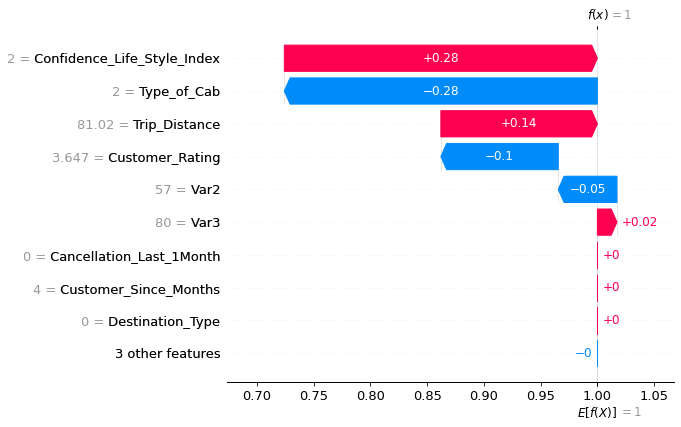

In [15]:
shap.plots.waterfall(shap_values[0])

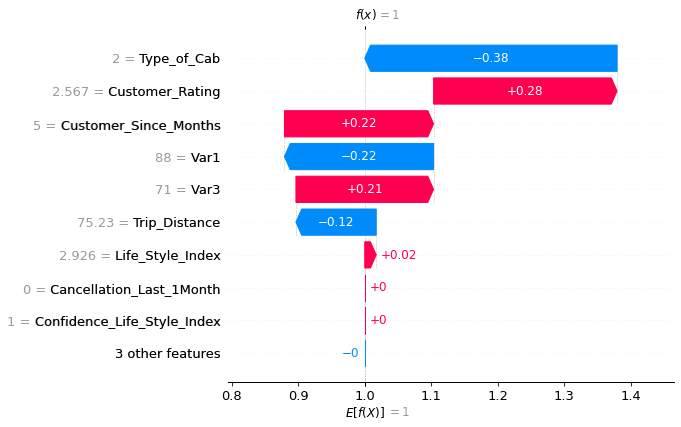

In [18]:
shap.plots.waterfall(shap_values[1])

**Note** that in the above explanation the three least impactful features have been collapsed into a single term so that we don’t show more than 10 rows in the plot.

In [ ]:
# shap.plots.waterfall(shap_values[20])

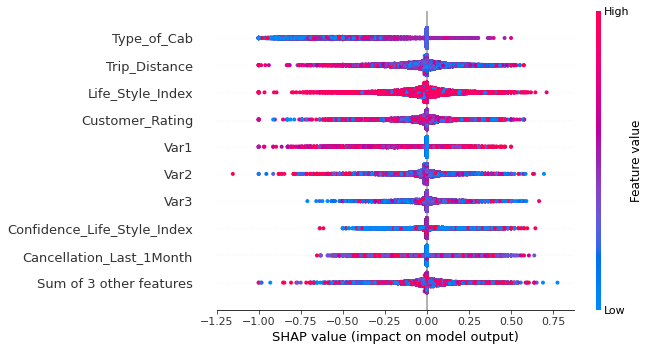

In [33]:
shap.plots.beeswarm(shap_values)

### Discussion: 
From this plot, we can get a group information about all the features displayed on y-axis. This highlights that as the value for Type_of_Cab increases, the surge pricing values also increases.

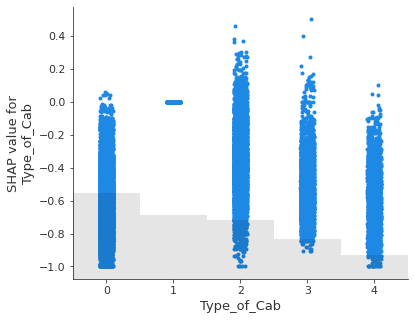

In [28]:
shap.plots.scatter(shap_values[:,"Type_of_Cab"])

### Discussion:
This scatter plot is call Dependence contribution plot shows that Type Of Cab corresponds to High Surge Pricing Type.

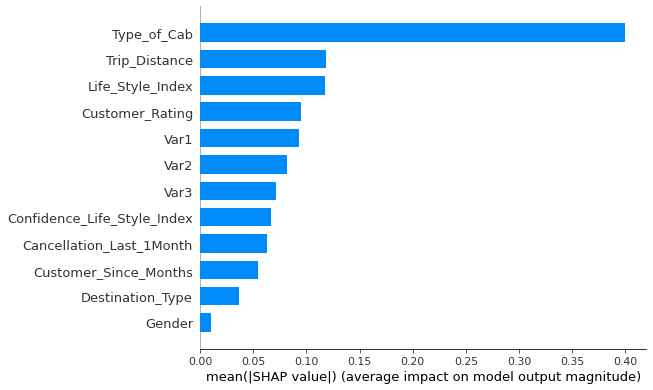

In [27]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Dsicussion:

According to shap analysis, **Type of Cab**  is the most vital feature while predicting Surge Pricing Type for the customers, while **Gender**, **Destination Type** and **Customer Since months** are less important in decisin making.

In [32]:
# shap.plots.heatmap(shap_values[1])

### Calculating importance (by permutation)

In [35]:
perm = PermutationImportance(clf, random_state=1).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())

Weight,Feature
0.1508 ± 0.0036,Type_of_Cab
0.0291 ± 0.0065,Trip_Distance
0.0288 ± 0.0033,Life_Style_Index
0.0229 ± 0.0038,Confidence_Life_Style_Index
0.0154 ± 0.0041,Cancellation_Last_1Month
0.0138 ± 0.0042,Customer_Rating
0.0132 ± 0.0030,Var3
0.0108 ± 0.0024,Var1
0.0092 ± 0.0032,Var2
0.0090 ± 0.0026,Destination_Type


From this table, we can say that Type_of_Cab and Trip_Distance are highly important features in prediction

### Playing with Normalize data

In [44]:
# normalize data
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
X_train_norm = X_train.copy()
X_valid_norm = X_valid.copy()
for k,dtype in dtypes:
    m = X_train[k].mean()
    s = X_train[k].std()
    X_train_norm[k] -= m
    X_train_norm[k] /= s

    X_valid_norm[k] -= m
    X_valid_norm[k] /= s

In [45]:
# knn_norm = sklearn.neighbors.KNeighborsClassifier()
# knn_norm.fit(X_train_norm, y_train)

clf2 = tree.DecisionTreeClassifier()
clf2 = clf.fit(X_train_norm, y_train)

In [46]:
# f = lambda x: knn_norm.predict_proba(x)[:,1]
# med = X_train_norm.median().values.reshape((1,X_train_norm.shape[1]))

# explainer = shap.Explainer(f, med)

# shap_values_norm = explainer(X_valid_norm.iloc[0:100,:])

f = lambda x: clf2.predict_proba(x)[:,1]
med = X_train_norm.median().values.reshape((1,X_train_norm.shape[1]))

explainer = shap.Explainer(f, med)
shap_values_norm = explainer(X_valid_norm.iloc[0:100,:])

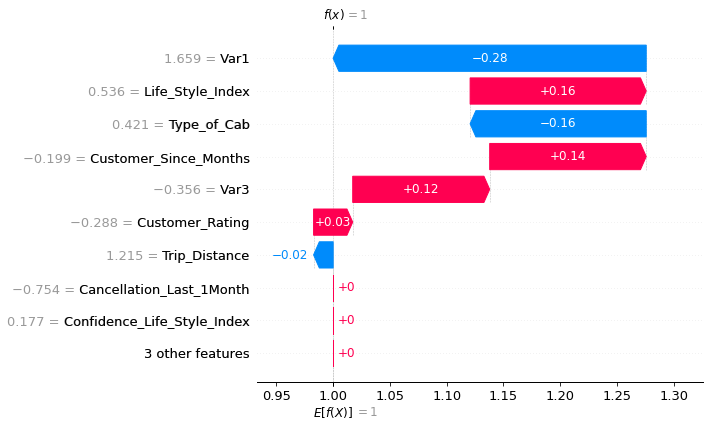

In [47]:
shap.plots.waterfall(shap_values_norm[1])

### Discussion:
After normalizing the data, Var1 and Life_Style_Index move to the top, while Type of Cab moves down to the 3rd place.

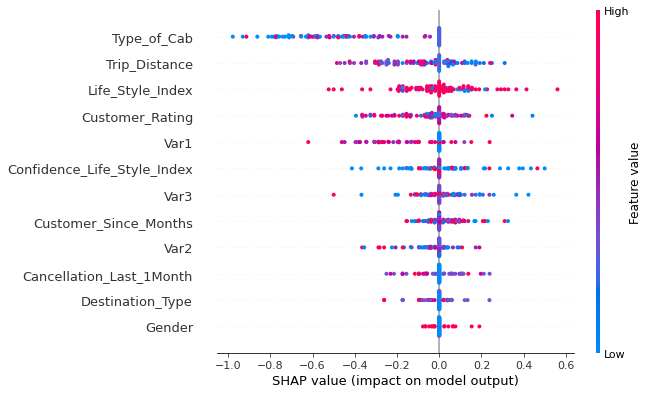

In [48]:
shap.summary_plot(shap_values_norm, X_valid.iloc[0:100,:])

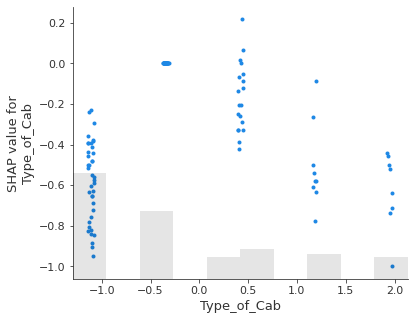

In [26]:
shap.plots.scatter(shap_values_norm[:,"Type_of_Cab"])

Since waterfall plots only show a single sample worth of data, we can’t see the impact of changing capital gain. To see this we can use a scatter plot, which shows how low values for captial gain are a more negative predictor of income that no captial gain at all. 

In [39]:
#

### PDP plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


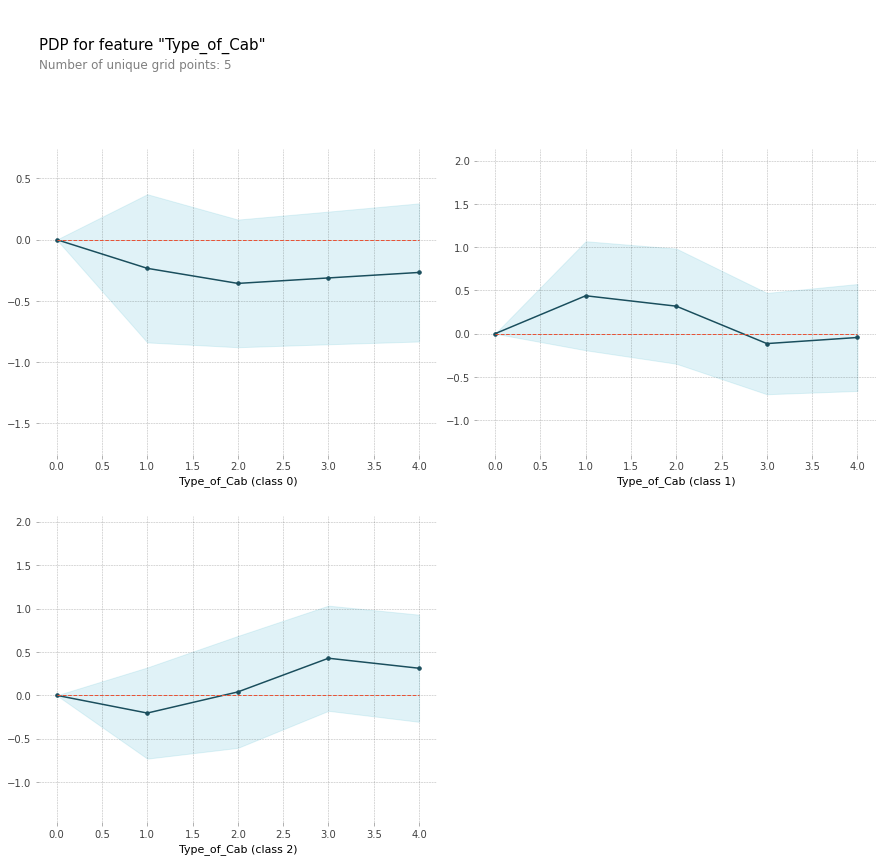

In [38]:
from pdpbox import pdp, get_dataset, info_plots
import matplotlib.pyplot as plt
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=clf,dataset=X_valid, 
                            model_features=X_valid.columns.tolist(),
                            feature='Type_of_Cab')
# plot it
pdp.pdp_plot(pdp_goals, 'Type_of_Cab')
plt.show()

1. For each class of Type_Of_Cab, the range values differ, for example in class 0, values > 1 corresponds to improved Pricing.

2. For class 1, values > 3.0 improves the predictions

3. For class 3, they should be less 2.0


### LIME

#### Analyze predictions with LIME;

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 10.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=9698a9acbc2e7c2c71a8385cad41e6a54ed59f98c38479e22334a4aeb0ecc188
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import lime
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function

In [ ]:
features = X_train.columns
features

Index(['Cancellation_Last_1Month', 'Confidence_Life_Style_Index',
       'Customer_Rating', 'Customer_Since_Months', 'Destination_Type',
       'Gender', 'Life_Style_Index', 'Trip_Distance', 'Type_of_Cab', 'Var1',
       'Var2', 'Var3'],
      dtype='object')

In [ ]:
X_train.values.shape

(712, 16)

In [ ]:
X_train.values[0]

array([ 3.        , -0.29690209,  0.        ,  0.        ,  0.        ,
       -2.13070136,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [ ]:
len(features)

16

## Training Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [ ]:
predict_fn_logreg = lambda x: model.predict_proba(x).astype(float)

### Create the LIME Explainer

In [ ]:
X_train.shape, y_train.shape

((105329, 12), (105329,))

### **LIME Explainer**

In [ ]:
# Create the LIME Explainer
explainer2 = lime.lime_tabular.LimeTabularExplainer(X_train.values ,feature_names = features,
                                                   class_names=['1','2','3'],
                                                   kernel_width=3)

# Pick the observation in the validation set for which explanation is required
observation_1 = 2

# # Get the explanation for Logistic Regression
exp = explainer2.explain_instance(X_valid.values[0], predict_fn_logreg)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


## Conclusion:

Based on plots and model's results, it can concluded that Surge_pricing increases with the Type_of_Cab being ordered and the total trip distance. Features such as Gender do not have much role in the prediction and can be ignored.